# Mentoría 'de cómo clasificar en géneros a las canciones'
## Práctico I : Análisis de features de audio

### Dependencias y acceso al API

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import pi
import plotly.express as exp
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_id = '46b333d567314a89a6254b6c6b054be6'
client_secret = '9d922c3613e441518349dcf55f7d5853'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

---------------------------------------------------------------------------------

**Alumno**: Hilal, Guillermo

**Junio 2020**

#### La pregunta que se buscará responder será:
### ¿Por qué este artista destaca dentro de su género?

#### *Aclaraciones*: 
   - Se comparará la banda a analizar con otra del mismo género pero con menor difusión.
   - Las bandas con las que se trabajarán serán Bándalos Chinos (BC) (banda a analizar) y De La Rivera (DLR) ("competencia").
   - Ambas son bandas que trabajan con géneros muy parecidos: pop, electropop y funk.
   - De La Rivera posee una trayectoria mayor respecto a Bándalos Chinos, por lo cual poseen mayor cantidad de albumes y tracks. Se tomó una muestra de canciones de De La Rivera igual a la cantidad de canciones de Bándalos Chinos para facilitar y normalizar el análisis.
    
#### *Features*: 
#### Las features extraídas de cada track son las siguientes:

   - **name** : Nombre del track.
   - **date** : Fecha de lanzamiento del album del track.
   - **duration_ms** : Duración del track en milisegundos.
   - **key** : Tonalidad del track. Cada número se corresponde a una nota, siendo 0 el Do, 1 el Do Sostenido (Re Bemol) y así.
   - **mode** : Modo del track. El 1 corresponde a mayor y 0 a menor.
   - **tempo** : Tempo general estimado medido en BPN de un track.
   - **loudness** : El volumen general del track medido en decibeles (dB).
   - **valence** : Medida entre 0 y 1 de la positividad que transmite el track.
   - **energy** : Medida (perceptual) de intesidad y actividad de un track. Se ubica entre 0 y 1.
   - **danceability** : Medida entre 0 y 1 de cuán "bailable" es un track en base a diversos elementos musicales como el ritmo, el tempo o la regularidad general del track.

---------------------------------------------------------------------------------

### Extracción de tracks

In [2]:
# Exrtracción de todos los álbumes de un artista

def get_albums(artist_id):
    albums_js = sp.artist_albums(artist_id=artist_id, country='ar')
    albums = albums_js['items']
    artist = albums[0]['artists'][0]['name']
    print("\n-----Extrayendo features de " + artist+'-----')
    return artist, albums

In [3]:
# Extracción de todos los tracks de cada album 
def get_tracks(albums):
    
    tracks_df = pd.DataFrame(columns=('id','name'))

    for album in albums:
        tracks_js = sp.album(album['id'])
        r_date = tracks_js['release_date']
        
        tracks = tracks_js['tracks']['items']

        for i in range(len(tracks)):
            track = {'id':tracks[i]['id'], 'name':tracks[i]['name'], 'date':r_date}
            tracks_df= tracks_df.append(track, ignore_index=True)
    
    
    return tracks_df

---------------------------------------------------------------------------------

### Extracción y seteo de features

In [4]:
# Se reemplaza el mode de su forma numérica por la verbal
def replace_mode(mode):
    if mode == 1:
        return 'Major'
    else:
        return 'Minor'

In [5]:
# Se reemplaza la tonalidad por en su forma numérica por cifrado americano
def replace_key(key_):
    key_dict = {0:'C', 1:'C#', 2:'D', 3:'D#', 4:'E', 5:'F', 6:'F#', 7:'G', 8:'G#', 9:'A', 10:'A#', 11:'B'}
    return key_dict[key_]

In [6]:
# Creación  y guardado de dataframe de features para el artista
def set_and_save_dataframe(features_df, tracks_df, artist):
    features_df = features_df.reset_index()
    features_df = features_df.drop(columns=['index', 'speechiness', 'acousticness', 'instrumentalness', 'type', 'uri', 'track_href', 'analysis_url', 'time_signature', 'liveness'])
    
    final_df = pd.merge(tracks_df, features_df, on='id')
    final_df = final_df.drop_duplicates('name')
    
    final_df = final_df.reset_index()
    final_df = final_df.drop(columns=['index'])
    
    final_df['mode'] = final_df['mode'].apply(lambda x: replace_mode(x))
    final_df['key'] = final_df['key'].apply(lambda x: replace_key(x))
    
    final_df = final_df.reindex(['id', 'name', 'date', 'duration_ms', 'key', 'mode', 'tempo', 'loudness', 'valence', 'energy', 'danceability'], axis=1)
    final_df.to_csv('features_'+artist+'.csv')
    
    return final_df

In [7]:
def get_tracks_features(artist,artist_id, albums=None):
    
    tracks_df = get_tracks(albums)
    features_df = pd.DataFrame()

    for idx, row in tracks_df.iterrows():
        features = sp.audio_features(row.id)
        features_df = features_df.append(features)
    final_df = set_and_save_dataframe(features_df,tracks_df,artist)
    final_df = final_df.sort_values(by='date')
    final_df = final_df.reset_index()
    final_df = final_df.drop(columns=['index'])
    return final_df

In [8]:
def get_artist_tracks_features(artist_id):
    artist, albums = get_albums(artist_id)
    tracks_data = get_tracks_features(artist, artist_id, albums=albums)
    print('\n-----Extracción finalizada!-----')
    return tracks_data

---------------------------------------------------------------------------------

### Procesamiento

In [37]:
de_la_rivera_features_temp = get_artist_tracks_features('4U48zETkokPB76fnXQiO2b')
bandalos_chinos_features = get_artist_tracks_features('0wn2qDKzeFlhjRUtJAwJjp')



-----Extrayendo features de De La Rivera-----

-----Extracción finalizada!-----

-----Extrayendo features de Bandalos Chinos-----

-----Extracción finalizada!-----


In [39]:
#Se adapta la cantidad de datos de la banda De La Rivera a la cantidad de datos de Bandalos Chinos
de_la_rivera_features = de_la_rivera_features_temp.tail(n=bandalos_chinos_features.shape[0])
de_la_rivera_features = de_la_rivera_features.sort_values(by='date')
de_la_rivera_features = de_la_rivera_features.reset_index()
de_la_rivera_features = de_la_rivera_features.drop(columns=['index'])


In [40]:
de_la_rivera_features

,id,name,date,duration_ms,key,mode,tempo,loudness,valence,energy,danceability
0,6N5fNGYcVboEkQkzzvut5U,Icarus,2018-09-21,262300,G,Major,119.944,-8.429,0.212,0.608,0.705
1,4Agbw6N8EpvucO1jq1L1jL,Haremos Pedazos el Mundo,2018-09-21,200958,A,Minor,94.183,-7.533,0.792,0.568,0.723
2,30YglG7HRkeOCuVHwJNybP,Días Desiertos,2018-09-21,238470,A,Minor,110.008,-5.603,0.560,0.799,0.616
3,7JwEWnIqWF36wWDIUZqbfY,Envuelve,2018-09-21,243320,B,Minor,101.992,-8.279,0.642,0.787,0.656
4,7CbfBD8EXReaeLY3r8Najv,Intro / Narita,2018-09-21,352610,E,Minor,114.976,-10.741,0.254,0.570,0.647
5,17qDYslrViOYcqFkwvgsGg,Waves,2018-09-21,235080,A,Minor,120.004,-6.356,0.964,0.839,0.847
6,1IHSGMQbzSs5l7BP4PPex9,Something About You,2018-09-21,265310,A,Minor,95.002,-9.163,0.615,0.468,0.664
7,0TgosmN4trzclGFrAZkSP7,Carolyn - Radio Edit,2018-09-21,198556,E,Minor,119.987,-6.061,0.855,0.869,0.755
8,5JzU4H9nhqjLgV6hcbnTyd,Conmigo,2018-09-21,260880,B,Minor,99.976,-6.914,0.481,0.694,0.633
9,4X0m9w58gg3MkZgiLzI7hP,La Rubia Tarada,2018-11-16,264047,A#,Minor,120.007,-7.370,0.824,0.572,0.905


In [41]:
bandalos_chinos_features

,id,name,date,duration_ms,key,mode,tempo,loudness,valence,energy,danceability
0,5eeYFL59olH5RPMASwhxEW,Chino Town II,2014-12-15,139569,B,Minor,131.884,-8.985,0.0376,0.522,0.164
1,2mzhcXrtHmpNLH6fTYprv7,Chino Town I,2014-12-15,194144,F,Major,143.396,-8.142,0.7030,0.617,0.515
2,4zlNaFyXdaKNtnBEOIVKED,Rana Fénix,2014-12-15,231041,E,Minor,178.054,-6.796,0.7410,0.722,0.557
3,5vFCgpbbAQY3xxhNzu1MUS,Russia,2014-12-15,233124,G,Major,151.467,-7.878,0.3440,0.747,0.255
4,3mXnIe0oRVMCqk0qTawTFu,Correr,2014-12-15,231127,C,Major,139.106,-7.242,0.7840,0.616,0.562
5,14GDbRuhUgkv25X0nWJ31R,Nunca Estuve Acá,2014-12-15,258646,A#,Major,73.579,-6.164,0.7260,0.704,0.255
6,6ACrXozc2ksCAhHl63uZtv,Isla - Pyura Remix,2016-12-12,307061,A,Minor,109.019,-10.116,0.6360,0.550,0.704
7,6Ou8XuP4sl1Sn6C1uw6v5Z,Un Día,2016-12-23,196802,B,Minor,181.932,-8.101,0.2990,0.712,0.462
8,3vuBlDXJskPH4SOfqwHRes,El Verano,2016-12-23,254848,D,Major,92.001,-7.435,0.1020,0.641,0.520
9,0WQbW3BDhSSQIAQd7H531u,Veccar,2016-12-23,346131,F#,Minor,124.979,-10.830,0.0907,0.452,0.629


---------------------------------------------------------------------------------

### Cálculo de media y mediana de features

In [42]:
# Se calcula media y mediana para cada artista
def get_statistic_df(df_features, statistic):
    
    if statistic == 'mean':
        features_statistic = df_features.mean()
        
    elif statistic == 'median':
        features_statistic = df_features.median()
              
    df_statistic_values = pd.DataFrame(features_statistic, columns=[statistic])
    df_statistic_values.index.name = 'features'
    
    return df_statistic_values

In [43]:
def get_features_statisctic_values(df_features):
#     df_features = load_dataframe(band)
    df_mean = get_statistic_df(df_features, 'mean')
    df_median = get_statistic_df(df_features, 'median')
    
    df_statistics = pd.merge(df_mean, df_median, on='features')
    
    return df_statistics

In [44]:
df_stat_BC = get_features_statisctic_values(bandalos_chinos_features)
df_stat_DR = get_features_statisctic_values(de_la_rivera_features)

In [45]:
df_stat_BC

,mean,median
features,,
duration_ms,229710.083333,228080.0000
tempo,122.632972,124.4585
loudness,-7.310139,-7.2160
valence,0.583342,0.6860
energy,0.630222,0.6425
danceability,0.636556,0.6775


In [46]:
df_stat_DR

,mean,median
features,,
duration_ms,230702.972222,231643.500
tempo,114.059944,118.012
loudness,-6.804889,-7.050
valence,0.724944,0.753
energy,0.703083,0.690
danceability,0.745556,0.739


In [47]:
# Dataframe general con los valores de los estadísticos de cada feature para cada artista
df_statisctics = pd.merge(df_stat_BC, df_stat_DR, on='features')
df_statisctics = df_statisctics.rename(index=str, columns={'mean_x':'BC_mean','median_x':'BC_median', 
                                                'mean_y':'DR_mean', 'median_y':'DR_median'})

df_statisctics

,BC_mean,BC_median,DR_mean,DR_median
features,,,,
duration_ms,229710.083333,228080.0000,230702.972222,231643.500
tempo,122.632972,124.4585,114.059944,118.012
loudness,-7.310139,-7.2160,-6.804889,-7.050
valence,0.583342,0.6860,0.724944,0.753
energy,0.630222,0.6425,0.703083,0.690
danceability,0.636556,0.6775,0.745556,0.739


---------------------------------------------------------------------------------

### Comparación de estadísticos

In [48]:
# Se transpone el dataframe para facilitar el gráfico de los valores

df = df_statisctics[['BC_mean', 'DR_mean' ]].transpose()
df = df.reset_index()

df = df.rename(columns={'index':'band_statistic'})
df

features,band_statistic,duration_ms,tempo,loudness,valence,energy,danceability
0,BC_mean,229710.083333,122.632972,-7.310139,0.583342,0.630222,0.636556
1,DR_mean,230702.972222,114.059944,-6.804889,0.724944,0.703083,0.745556


  
   #### Features:
   - **Valence**
   - **Energy**
   - **Danceability**

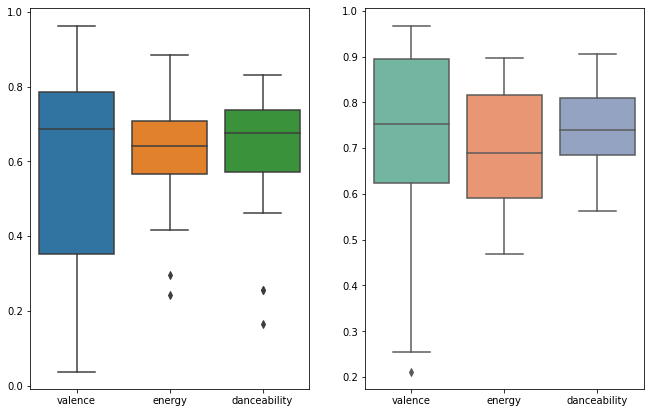

In [49]:
fig, ax =plt.subplots(1,2, figsize=(11,7),)

sns.boxplot(data=bandalos_chinos_features[['valence', 'energy', 'danceability']], ax=ax[0])
sns.boxplot(data=de_la_rivera_features[['valence', 'energy', 'danceability']], ax=ax[1], palette="Set2")

En base al gráfico anterior, se observa que la media de DLR en todas las features es mayor respecto a las medias de BC. Además se pueden observar los outliers de las features y la desviación estándar de cada una de las features.

---------------------------------------------------------------------------------

### Análisis de features Inherentes

Para comenzar, se analizarán features inherentes del artista a lo largo de sus tracks:
   - "Key" o "Tonalidad" 
   - "Mode" o "Modo" 
   - Tempo (BMP)
   - Duración (ms)
   - Loudness (dB)

#### *Key - Tonalidad*

Text(0.5, 1.0, 'Tonalidades utilizadas por De La Rivera')

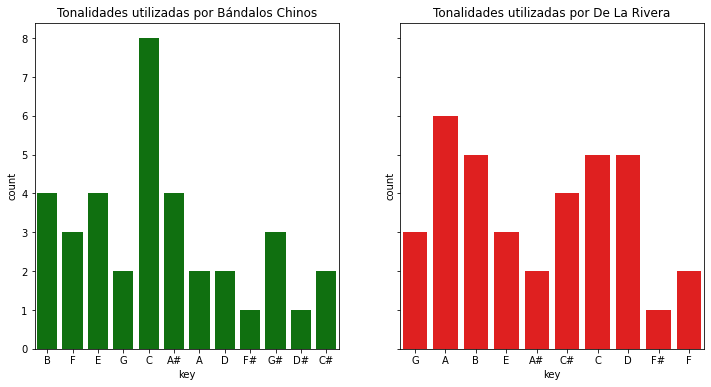

In [51]:
fig, ax =plt.subplots(1,2, figsize=(12,6), sharey=True)

sns.countplot(bandalos_chinos_features["key"],ax=ax[0],color="green").set_title('Tonalidades utilizadas por Bándalos Chinos')
sns.countplot(de_la_rivera_features["key"], ax=ax[1],color="red").set_title('Tonalidades utilizadas por De La Rivera')


Respecto a la tonalidad, podemos observar que, respecto al rango tonal, Bándalos Chinos opta por variar las tonalidades utilzadas a lo largo de sus discos. En total se denotan 12 tonalidades distintas (con un predominio de canciones en Do/C) en un total de 36 canciones, mientras que De La Rivera se mantiene en 10 tonalidades en la misma cantidad de canciones (con un predominio de canciones en La/A).


---------------------------------------------------------------------------------

#### *Mode - Modo*

Text(0.5, 1.0, 'Modos utilizados por De La Rivera')

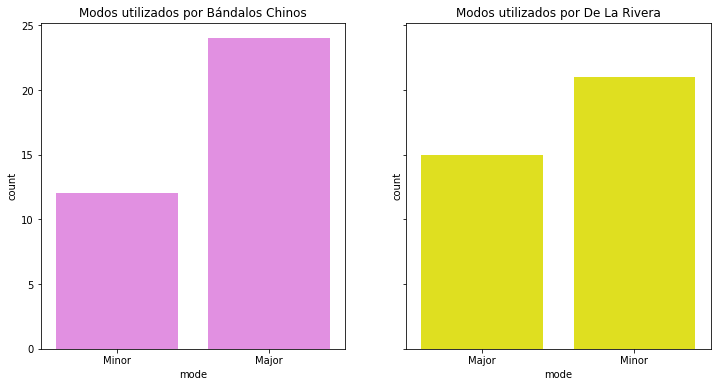

In [52]:
fig, ax =plt.subplots(1,2, figsize=(12,6), sharey=True)

sns.countplot(bandalos_chinos_features["mode"],ax=ax[0],color="violet").set_title('Modos utilizados por Bándalos Chinos')
sns.countplot(de_la_rivera_features["mode"], ax=ax[1],color="yellow").set_title('Modos utilizados por De La Rivera')

En cuanto al modo de las canciones, Bándalos Chinos mantiene una modalidad mayor para gran parte de sus canciones, mientras que De La Rivera opta por modos menores.


Ambas features fuera de contexto no aportan gran información ya que la tonalidad o el modo muchas veces se ven condicionados por factores propios de la banda como los registros vocales de las voces o el estilo que adopte la banda, pero permiten a su vez explicar porqué features que analizaremos después toman determinados valores.


---------------------------------------------------------------------------------

#### *Tempo*

Text(0.5, 1.0, 'Tempo DLR')

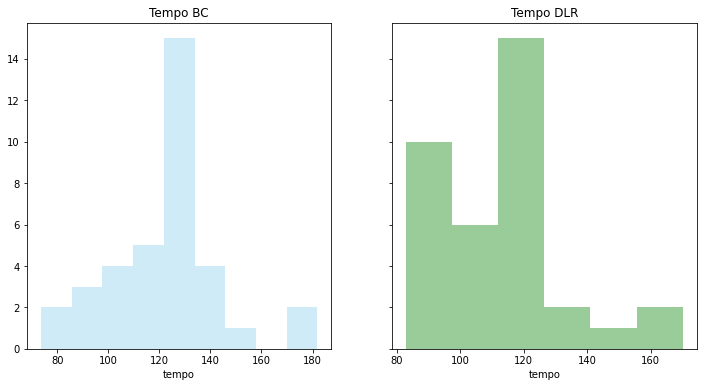

In [53]:
fig, ax =plt.subplots(1,2, figsize=(12,6), sharey=True)

sns.distplot(bandalos_chinos_features["tempo"],ax=ax[0],color="skyblue", kde=False, norm_hist=False).set_title("Tempo BC")
sns.distplot(de_la_rivera_features["tempo"],ax=ax[1],color="green", kde=False, norm_hist=False).set_title("Tempo DLR")


Text(0.5, 0.98, 'Tempo a través de sus canciones')

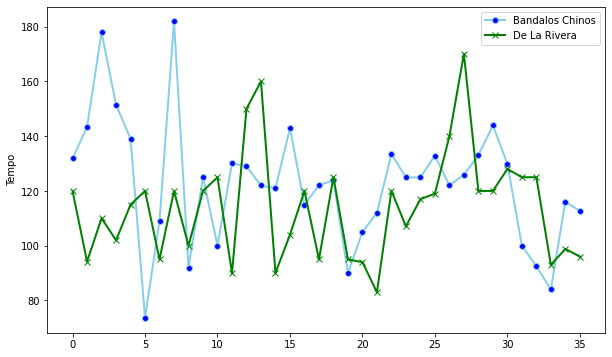

In [54]:
plt.figure(figsize=(10,6))

plt.plot('tempo', data=bandalos_chinos_features, marker='.', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2, label="Bandalos Chinos")
plt.plot('tempo', data=de_la_rivera_features, marker='x', color='green', linewidth=2, label="De La Rivera")
plt.ylabel("Tempo")
plt.legend()
fig.suptitle("Tempo a través de sus canciones", fontsize=20)

En base al primer gráfico se observa que BC opta en la mayoría de sus tracks por utilizar tempos entre 120 y 130 BMP en su mayoría, con pocos tracks con valores mayores o menores. Por otra parte, DLR utiliza tempos más próximos a los 120 BPM o incluso menores.

A partir del gráfico, se visualiza que BC en sus primeros discos maneja tempos muy variables entre sus canciones. Se puede ver en los primeros valores que adquiere la función ya que posee picos y valles muy juntos. A medida que la banda evolciona a través de sus discos, comienza a manejar tempos que rondan los 120 BPM.

Por otro lado DLR comienza con tempos que rondan los 120 BPM pero a medida que avanzan en su trayectoria, comienzan a utilizar tempos más altos con picos en 170 inclusive y descendiendo en el último año.

---------------------------------------------------------------------------------

#### *Duración*

Text(0.5, 1.0, 'Duración DLR')

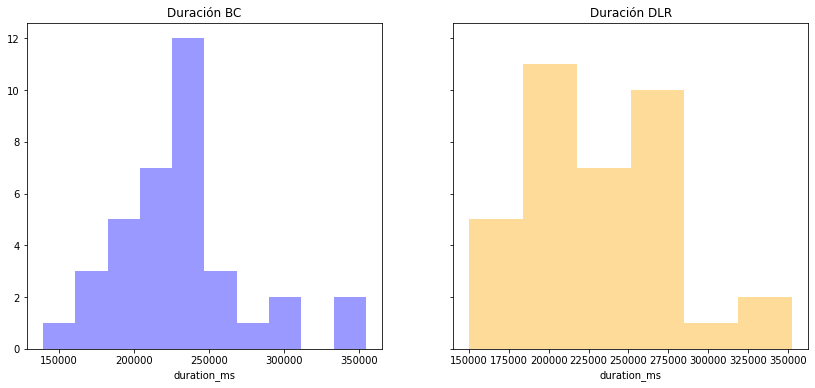

In [57]:
fig, ax =plt.subplots(1,2, figsize=(14,6), sharey=True)
sns.distplot(bandalos_chinos_features["duration_ms"],ax=ax[0],color="blue", kde=False, norm_hist=False).set_title("Duración BC")
sns.distplot(de_la_rivera_features["duration_ms"],ax=ax[1],color="orange", kde=False, norm_hist=False).set_title("Duración DLR")

Text(0.5, 0.98, 'Duración de tracks')

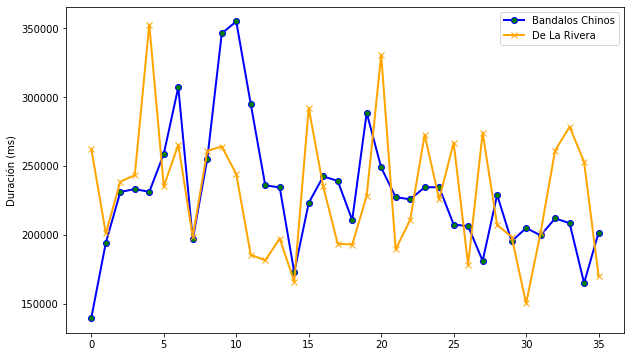

In [56]:
plt.figure(figsize=(10,6))

plt.plot('duration_ms', data=bandalos_chinos_features, marker='.', markerfacecolor='green', markersize=12, color='blue', linewidth=2, label="Bandalos Chinos")
plt.plot('duration_ms', data=de_la_rivera_features, marker='x', color='orange', linewidth=2, label="De La Rivera")
plt.ylabel("Duración (ms)")
plt.legend()
fig.suptitle("Duración de tracks", fontsize=20)

En base al primer gráfico podemos observar que la duración de las canciones se concentra en mayor medida entre los 200000 y 250000 milisegundos mientras que en el gráfico de DLR se agrupan valores regularmente entre los  180000 y los 280000 milisegundos.
Por otra parte, en el segundo gráfico observa que, más allá de que BC varía en la duración de sus tracks, las diferencias son menos pronunciadas respecto a los tracks de DLR a medida que avanza la trayectoria de ambas bandas. BC mantiene más regular la duración de sus tracks.

---------------------------------------------------------------------------------

#### *Loudness*

Text(0.5, 1.0, 'De La Rivera Loudness (dB)')

<Figure size 864x576 with 0 Axes>

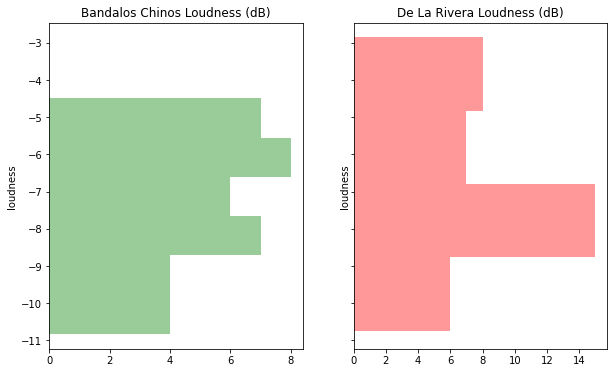

In [58]:
plt.figure(figsize=(12, 8))
fig, ax =plt.subplots(1,2, figsize=(10,6), sharey=True)
sns.distplot(bandalos_chinos_features["loudness"],ax=ax[0],color="green", kde=False, norm_hist=False, vertical=True).set_title('Bandalos Chinos Loudness (dB)')
sns.distplot(de_la_rivera_features["loudness"],ax=ax[1],color="red", kde=False, norm_hist=False, vertical=True).set_title('De La Rivera Loudness (dB)')


Loudness es una de las features donde se visualiza mayor diferencia entre ambas bandas. Mientras BC maneja un rango de loudness que va entre -11 dB a -4 aproximadamente, DLR maneja un rango más amplio que va de -11 a -2 aproximadamente. 

(Cabe destacar que los valores que adquiere esta feature varían según la técnica de producción, mezcla y compresión optada por la banda en cada track)

---------------------------------------------------------------------------------

### Análisis de features de Spotify

#### Las próximas features a analizar son generadas por la API de Spotify y surgen de la combinación de características sonoras de los tracks. Estas son:
   - Valence
   - Energy
   - Danceability

---------------------------------------------------------------------------------

#### *Valence*

Text(0.5, 1.0, 'Valence DLR')

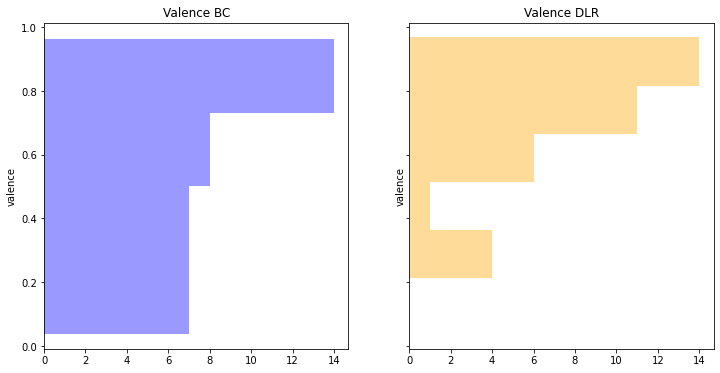

In [59]:
fig, ax =plt.subplots(1,2, figsize=(12,6), sharey=True)
sns.distplot(bandalos_chinos_features["valence"],ax=ax[0],color="blue", kde=False, norm_hist=False, vertical=True).set_title("Valence BC")
sns.distplot(de_la_rivera_features["valence"],ax=ax[1],color="orange", kde=False, norm_hist=False, vertical=True).set_title("Valence DLR")

Como se puede visualizar en el gráfico, los valores de "valence" presentan distribuciones muy parecidas entre ambas bandas, ambas muy próximas al 1 pero DLR mostrando mayor cantidad de valores más próximos al 1. Esto significa que, en base a lo que esta medida representa, los tracks de DLR presentan un mayor grado de "positividad musical" respecto a los de BC.

---------------------------------------------------------------------------------

#### *Energy*

Text(0.5, 1.0, 'Energy DLR')

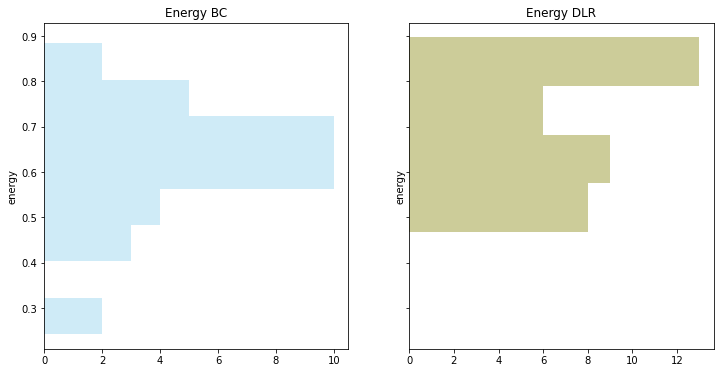

In [60]:
fig, ax =plt.subplots(1,2, figsize=(12,6), sharey=True)
sns.distplot(bandalos_chinos_features["energy"],ax=ax[0],color="skyblue", kde=False, norm_hist=False, vertical=True).set_title("Energy BC")
sns.distplot(de_la_rivera_features["energy"],ax=ax[1],color="olive", kde=False, norm_hist=False, vertical=True).set_title("Energy DLR")

A diferencia del valence, la energía de los tracks de ambas bandas presenta distribuciones distintas para cada caso. En el caso de BC, los valores se aproximan más a 0.6 mientras que en DLR se aproximan más a 1. Esto significa que en vistas generales, DLR presenta mayor "energía" en sus tracks que BC.

---------------------------------------------------------------------------------

#### *Danceability*

Text(0.5, 1.0, 'Danceability DLR')

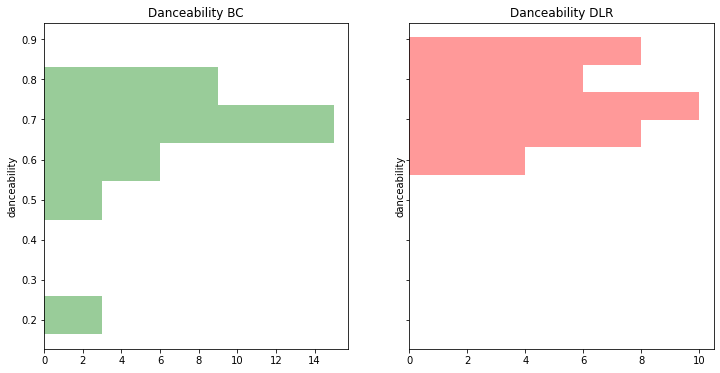

In [61]:
fig, ax =plt.subplots(1,2, figsize=(12,6), sharey=True)
sns.distplot(bandalos_chinos_features["danceability"],ax=ax[0],color="green", kde=False, norm_hist=False, vertical=True).set_title("Danceability BC")
sns.distplot(de_la_rivera_features["danceability"],ax=ax[1],color="red", kde=False, norm_hist=False, vertical=True).set_title("Danceability DLR")

En el caso de la feature "danceability" se observa que los tracks de DLR tienen mayor valor de danceability (son más "bailables") respecto a los de BC. BC agrupa mayor cantidad de valores cerca de 0.6 mientras que DLR agrupa mayor cantidad cerca de 0.8.

---------------------------------------------------------------------------------

### *Correlaciones*

Más allá de que el análisis de las features por separado aporta información que permite responder la hipótesis inicial, la correlación entre las features termina de darle forma a las conclusiones previamente obtenidas.


#### **Energy & Valence**

Text(0.5, 1.08, 'BC Energy & Valence')

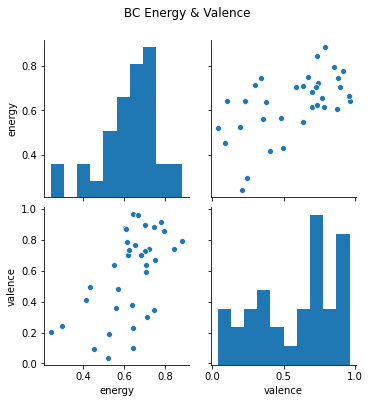

In [30]:
g = sns.pairplot(bandalos_chinos_features[['energy', 'valence']])
g.fig.suptitle("BC Energy & Valence", y=1.08)

Text(0.5, 1.08, 'DLR Energy & Valence')

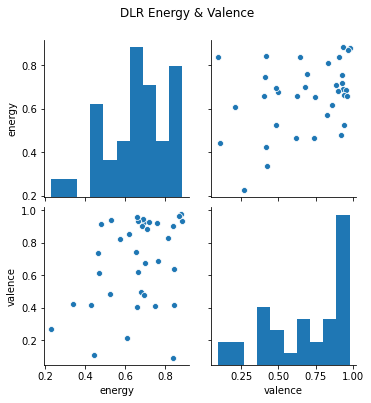

In [31]:
g = sns.pairplot(de_la_rivera_features[['energy', 'valence']])
g.fig.suptitle("DLR Energy & Valence", y=1.08)

A partir de los pairplots anteriores se puede observar la relación entre las features Energy y Valence para cada banda.

En el caso de BC, se puede ver que a medida que una de estas dos toma valores más próximos a 1, la otra también, lo que permite asumir que ambas variables son directamente proporcionales. Sin embargo DLR presenta casos donde una de las features toma un valor próximo a 1 y la otra un valor más cerca de 0, posee una distribución más heterogénea.

Esto significa que los tracks de BC con mayor energía mantienen un alto nivel de "positividad transmitida" a diferencia de DLR donde no se relacionan directamente estas features. 
Este comportamiento de las features de ambas bandas puede deberse a la tendencia de cada banda de optar por modos mayores o menores en sus tracks. Se asocian los modos mayores a estados más positivos, alegres; mientras que los menores a la tristeza o nostalgia. Mayor uso de modos mayores implicará una mayor valencia en los tracks en muchos casos.

#### **Danceability & Energy**

Text(0.5, 1.08, 'BC Danceability & Energy')

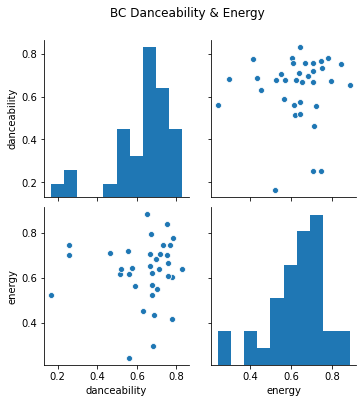

In [32]:
g = sns.pairplot(bandalos_chinos_features[['danceability', 'energy']])
g.fig.suptitle("BC Danceability & Energy", y=1.08)

Text(0.5, 1.08, 'DLR Danceability & Energy')

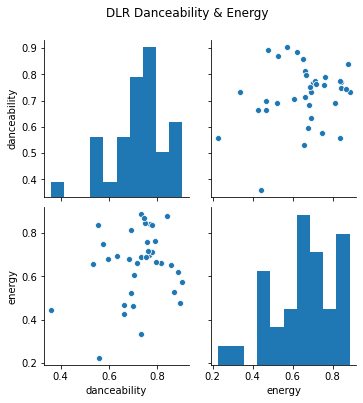

In [33]:
g = sns.pairplot(de_la_rivera_features[['danceability', 'energy']])
g.fig.suptitle("DLR Danceability & Energy", y=1.08)

A partir del gráfico se observa que la feature energy es directamente proporcional a danceability. Ambas bandas toman altos valores de ambas features pero DLR agrupa mayor cantidad de valores de ambas features cerca de 1. Esto se debe a la cercanía que tiene DLR a géneros como el funk o el electro funk, géneros más bailables respecto al electro pop de BC.

---------------------------------------------------------------------------------

### Ahora bien, ¿cómo respondemos a la pregunta planteada?

En base al análisis realizado, se pueden visualizar las características que le dan a Bandalos Chinos la popularidad o "fama" respecto a De La Rivera.

A pesar de que la banda cordobesa De La Rivera posee una mayor trayectoria respecto a la banda bonaerense Bandalos Chinos (tienen mayor cantidad de discos y canciones lanzadas desde el año 2010) y ambas encontrarse dentro del género Pop, Bandalos Chinos creció y ganó una mayor popularidad en los últimos años.

### ¿Cómo podemos justificar esta popularidad de una banda respecto a la otra con las features?

#### Features Inherentes:
   
   - "Key" o "Tonalidad": Lo que caracteriza a BC respecto a bandas del mismo género como DLR en este caso, es el uso de distintas tonalidades a lo largo de sus canciones, no solo hablando en términos de tonalidad general del track (lo que visualizamos en el primer gráfico) sino también las modulaciones dentro de un mismo track, es decir el paso de una tonalidad a otra. Por lo general las bandas del género suelen estancarse en las mismas tonalidades ya que se limitan a factores como por ejemplo el registro vocal de quien canta en la banda. 
   Otra particularidad que podemos observar del uso de tonalidades de BC es que a pesar de que este es muy variado, la banda se mantiene siempre en el mismo género. A esto lo podemos visualizar en la poca variación que hay de otras features como el tempo o la duración de sus canciones.
   
   
   - "Mode" o "Modo": Esta es una de las características de BC que más resalta respecto a DLR. El uso de modos mayores a lo largo de todos sus tracks es significativamente mayor respecto a DLR, que opta por utilizar modos menores.
   
   - Tempo (BMP): La mitad de los tracks de BC que conforman el dataset poseen un tempo entre 120 y 130 BPM, un tanto mayor a bandas del mismo género, como es el caso de DLR que optan por tempos más próximos a 115 o 120 BPM. Además, si se observan los últimos tracks lanzados por ambas bandas, el tempo en el caso de BC se mantiene cada vez más cerca de los 120 BPM o hasta incluso menos, mientras que DLR continúa experimentando con BMS más altos o más bajos a los 120.
   
- Duración (ms): Otra característica distintiva que posee BC es su estabilidad en cuanto a duración de sus tracks. Esta ronda entre los 2 y 3 minutos a lo largo de su trayectoria a diferencia de DLR que apuesta a tracks más largos en general.


- Loudness (dB): El volumen general de los tracks de BC no supera el rango de -10 a -4 dB, sus tracks se concentran dentro de esos valores. Como se mencionó previamente, el valor del loudness de un track puede variar según la técnica de compresión utilizada durante la mezcla del track y esto puede influir directamente en otras features del track.

#### Features de Spotify:

- Valence: La valencia de BC se caracteriza por concentrar valores cerca de 1 pero estar distribuída en todo el rango de 0 a 1 a diferencia de bandas como DLR que optan por tracks con mayor valencia. 


- Energy: En este caso, BC se mantiene con una energía en sus tracks regular respecto a otras bandas de su género, ya que los valores se concentran entre 0.5 y 0.6 en su mayoría.


- Danceability: En cuanto a cuán "bailables" son los tracks de BC respecto a DLR, se ve una gran diferencia entre ambos. DLR posee mayor cantidad de tracks con danceability cerca de 1 respecto a BC ya que múscia es más cercana al funk que la de BC, por lo que varios factores propios del género funk le dan la faceta bailable a sus canciones.


#### Conclusión:

En base al análisis de las features de los datos de los tracks de las bandas Bandalos Chinos y De La Rivera, se concluye que Bandalos Chinos tiene mayor popularidad o fama respecto a De La Rivera por la variedad de tonalidades, la adopción de modos mayores en la composición de sus tracks, tempos en su mayoría cerca de los 120 BPM, tracks de 2 a 3 minutos de duración y valencia, energía y danceability de sus tracks en valores regulares, próximos a 0.6.

Cabe destacar también que existen otros factores que influyen en gran medida en la popularidad del artista como ser la ubicación donde trabaja la banda: Bandalos Chinos es oriunda y está ubicada en Capital Federal, donde se concentra la mayor parte de la industria musical argentina; pero  son factores que exceden al propósito de este análisis.
